In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import math
import bisect

sys.path.insert(0, '../../..')

from cde.density_estimator import ExtremeValueMixtureDensityNetwork
from cde.density_estimator import MixtureDensityNetwork

from cde.data_collector import MatlabDataset, MatlabDatasetH5
from cde.density_estimator import plot_conditional_hist, measure_percentile, measure_percentile_allsame, measure_tail, measure_tail_allsame, init_tail_index_hill, estimate_tail_index_hill


/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/s

In [2]:
""" Open MATLAB file """

#matds = MatlabDataset('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
#matds = MatlabDataset('../../data/dataset_normal_400k.mat')
matds = MatlabDataset('../../data/fulldataset_gamma_400k.mat') 


 Dataset loaded from .mat file. Rows: 399997   Columns: 4 


In [3]:
""" Take conditioned samples and fit tail density model """

train_data = matds.get_data(40000)

Y = train_data[:,0]
X = train_data[:,1:]

print("Number of negative values in Y: " + str(np.size(np.where(Y < 0))))
print("Are there any NaN values in Y: " + str(np.isnan(Y).any()))

model = ExtremeValueMixtureDensityNetwork("GMM_powerlaw_mixture0", ndim_x=3, n_centers=10, ndim_y=1, n_training_epochs=2000, hidden_sizes=(32, 32),verbose_step=200,learning_rate=1e-3)

model.fit(X, Y)

Number of negative values in Y: 0
Are there any NaN values in Y: False
Step 0: train log-likelihood 168277.52
Step 200: train log-likelihood 54458.305
Step 400: train log-likelihood 50669.266
Step 600: train log-likelihood 49439.594
Step 800: train log-likelihood 49111.63
Step 1000: train log-likelihood 48996.81
Step 1200: train log-likelihood 48936.688
Step 1400: train log-likelihood 48902.867
Step 1600: train log-likelihood 48885.508
Step 1800: train log-likelihood 48860.844
Step 2000: train log-likelihood 48848.29


In [4]:
""" verbose function """

mx = np.array([[0,1,1],[0,1,1],[0,1,1],[0,1,1],[0,1,1]])
my = np.array([[7],[5.2],[6.44],[2],[10]])
model._verbose(mx,my)

[[0 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]]
[ 7.    5.2   6.44  2.   10.  ]
[[0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]]
[[2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]]
[[5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]]

In [17]:
""" test parameters """

mx = np.array([[0,1,1]])
#my = np.array([7])
weights, locs, scales = model._get_mixture_components(mx)
threshold, tail_param = model._get_tail_components(mx)
print("mixture weigths: "+str(weights)+", mixture locations: "+str(locs)+", mixture scales: "+str(scales)+", tail threshold: "+str(threshold)+" tail index: "+str(1/tail_param))

mixture weigths: [[0.00070524 0.00133336 0.00102995 0.05198918 0.69002086 0.00221135
  0.00445496 0.00107086 0.21719004 0.02999414]], mixture locations: [[[2.2153049]
  [2.921678 ]
  [2.1406946]
  [4.411988 ]
  [3.1942236]
  [5.602779 ]
  [2.1840353]
  [2.3788474]
  [3.8831136]
  [2.5458584]]], mixture scales: [[[0.01999543]
  [0.1331521 ]
  [0.0119356 ]
  [0.76883745]
  [0.5977846 ]
  [0.44693494]
  [0.16924313]
  [0.09688339]
  [0.718185  ]
  [0.18025376]]], tail threshold: [[5.6750164]] tail index: [[18.967672]]


In [5]:
""" test prob function """

mx = np.array([[0,1,1]])
my = np.array([[10]])
print(model.pdf(mx,my))

[4.2349207e-08]


In [7]:
""" test tail prob """

cond_state = [0,1,1]
mx = np.array([cond_state])
my = np.array([11])
print(model.tail(mx,my))


2.1716493e-09


In [8]:
""" Take conditioned samples and fit a Gaussian Mixture Model """
from cde.density_estimator import MixtureDensityNetwork

N_tr = len(train_data)

Y = train_data[:,0]
X = train_data[:,1:]

gmm_model = MixtureDensityNetwork("GMM_3hop_gamma1", ndim_x=3, n_centers=10, ndim_y=1,n_training_epochs=2000,hidden_sizes=(32, 32))
gmm_model.fit(X, Y)

2000/2000 [100%] ██████████████████████████████ Elapsed: 404s | loss: 44562.102
mean log-loss train: 1.1141


In [4]:
""" Save the trained model and the training data into file """

with open('saves/New_3hop_gamma_400k_3dim.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

np.save('saves/New_3hop_gamma_400k_3dim.npy', train_data)

In [11]:
""" Load the trained model and training dataset from file """

dummy = MixtureDensityNetwork("GMM_3hop_expar", ndim_x=2, ndim_y=1)
dummy._setup_inference_and_initialize()

with open('saves/New_3hop_gamma_400k_3dim.pkl', 'rb') as input:
    dummy = pickle.load(input)

model = dummy

train_data = np.load('saves/New_ds_gamma_400k_3dim.npy')

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 


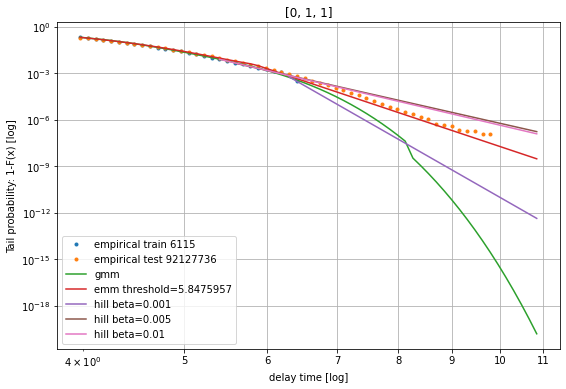

In [9]:
""" Open analysis MATLAB file - [0,1,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_1]_92M.mat')

cond_state = [0,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(gmm_model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

tailn=[]
for i in range(len(x)):
    mx = np.array([cond_state])
    my = np.array([x[i]])
    tailn.append(model.tail(mx,my))
tail_threshold, tail_param = model._get_tail_components(mx)
tail_threshold = np.squeeze(tail_threshold)

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(x,tailn, label="emm threshold=" + str(tail_threshold))

hillbetas = [0.001,0.005,0.01]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here

plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 65538430   Columns: 4 


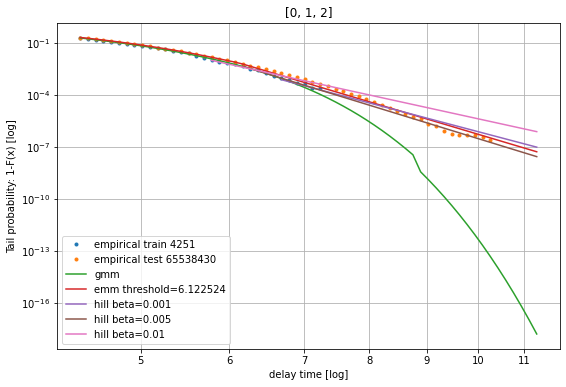

In [10]:
""" Open analysis MATLAB file - [0,1,2] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_2]_92M.mat')

cond_state = [0,1,2]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(gmm_model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

tailn=[]
mx = np.array([cond_state])
for i in range(len(x)):
    my = np.array([x[i]])
    tailn.append(model.tail(mx,my))
tail_threshold, tail_param = model._get_tail_components(mx)
tail_threshold = np.squeeze(tail_threshold)

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(x,tailn, label="emm threshold=" + str(tail_threshold))

hillbetas = [0.001,0.005,0.01]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here

plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 64248362   Columns: 4 


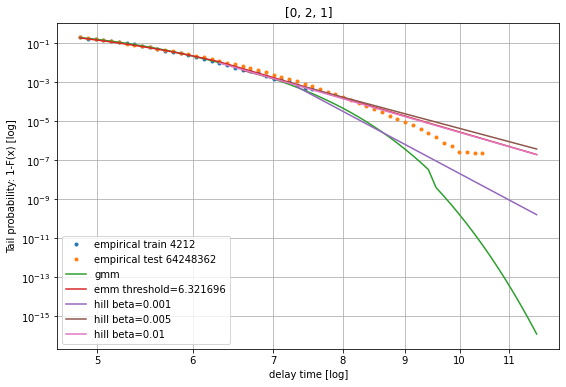

In [14]:
""" Open analysis MATLAB file - [0,2,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_2_1]_92M.mat')

cond_state = [0,2,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(gmm_model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

tailn=[]
for i in range(len(x)):
    mx = np.array([cond_state])
    my = np.array([x[i]])
    tailn.append(model.tail(mx,my))
tail_threshold, tail_param = model._get_tail_components(mx)
tail_threshold = np.squeeze(tail_threshold)

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(x,tailn, label="emm threshold=" + str(tail_threshold))

hillbetas = [0.001,0.005,0.01]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here

plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 55503665   Columns: 4 


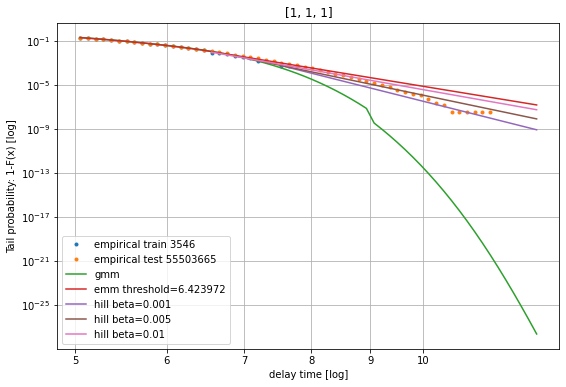

In [13]:
""" Open analysis MATLAB file - [1,1,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[1_1_1]_92M.mat')

cond_state = [1,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(gmm_model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

tailn=[]
for i in range(len(x)):
    mx = np.array([cond_state])
    my = np.array([x[i]])
    tailn.append(model.tail(mx,my))
tail_threshold, tail_param = model._get_tail_components(mx)
tail_threshold = np.squeeze(tail_threshold)

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
ax.loglog(x,tailn, label="emm threshold=" + str(tail_threshold))

hillbetas = [0.001,0.005,0.01]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here

plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

In [16]:
""" Open analysis MATLAB file - all states """

cond_matds_ar = []
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[0_1_1]_92M.mat'))
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[0_1_2]_92M.mat'))
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[0_2_1]_92M.mat'))
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[1_1_1]_92M.mat'))

cond_state_arr = [[0,1,1],[0,1,2],[0,2,1],[1,1,1]]

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(9*2,6*2))

for n in range(len(cond_state_arr)):
    ax = axs[int(n/2),n%2]
    test_data = cond_matds_ar[n].get_data(cond_matds_ar[n].n_records)
    cond_state = cond_state_arr[n]

    tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
    measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
    measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
    x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=50)
    #x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
    #print(x)

    tail=[]
    for i in range(len(x)):
        tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

    testd_sorted = np.sort(test_data[:,0])
    ftail=[]
    for i in range(len(x)):
        indx = bisect.bisect_left(testd_sorted, x[i])
        ftail.append((len(test_data)-indx)/len(test_data))

    #xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
    tailh=[]
    for i in range(len(x)):
        tailh.append(gmm_model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

    tailn=[]
    for i in range(len(x)):
        mx = np.array([cond_state])
        my = np.array([x[i]])
        tailn.append(model.tail(mx,my))
    tail_threshold, tail_param = model._get_tail_components(mx)
    tail_threshold = np.squeeze(tail_threshold)
    
    ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train)+ " samples", linestyle = 'None') #substitute actual plotting here
    ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test)+ " samples", linestyle = 'None') #substitute actual plotting here
    ax.loglog(x,tailh, label="gmm") #substitute actual plotting here
    ax.loglog(x,tailn, label="emm threshold=" + str(tail_threshold))

    #hillbetas = [0.001,0.003,0.005,0.01,0.02]
    #for j in range(len(hillbetas)):
    #    #dsh = matds.get_data(300000)
    #    hillbeta = hillbetas[j]
    #    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    #    if k == 0:
    #        continue
    #    xhill = []
    #    tailhill=[]
    #    for i in range(len(x)):
    #        if x[i]>xk:
    #            xhill.append(x[i])
    #            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    #    
    #    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here


    ax.set_xlabel('delay time [log]')
    ax.set_xticks([5,6,7,8,9,10,11])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylabel('Tail probability: 1-F(x) [log]')
    ax.set_title(str(cond_state))
    ax.legend()
    ax.grid()

plt.show()

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 65538430   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 64248362   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 55503665   Columns: 4 
../../../cde/BaseConditionalDensity.py:277: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, y, init_bound)[0]
../../../cde/BaseConditionalDensity.py:277: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, y, init_bound)[0]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 334

TypeError: object of type 'NoneType' has no len()